In [1]:
! which python
# ! pip install matplotlib
# ! pip install augmentdata

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/bin/python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os



In [3]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import keras
from keras.layers import Dense

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


Using TensorFlow backend.


In [4]:
from augmentdata import data_augment

In [5]:
def check_cm_others(y_actual,y_predict):
    from sklearn.metrics import confusion_matrix

    cm1 = confusion_matrix(y_actual,y_predict)
    print('Confusion Matrix : \n', cm1)

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    tn=cm1[0,0]
    fp=cm1[0,1]
    fn=cm1[1,0]
    tp=cm1[1,1]

    sensitivity1 = tp/(tp+fn)
    print('Sensitivity : ', sensitivity1 )

    specificity1 = tn/(tn+fp)
    print('Specificity : ', specificity1)
    recall=sensitivity1
    precision=tp/(tp+fp)

    print("Precision = ",precision)
    print("Recall = ",recall)

    f1_score=2*(precision*recall)/(precision+recall)

    print("F1 score = ",f1_score)

    return sensitivity1,specificity1,f1_score

In [6]:
def create_model(weight_path,input_dim):
    
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    model=None
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, 
                activation='relu')) 

    model.add(Dense(20, 
                activation='relu'))
    model.add(Dense(20, 
                activation='relu'))

    model.add(Dense(20, 
                activation='relu'))

    model.add(Dense(20, 
                activation='relu'))
    model.add(Dense(20, 
                activation='relu'))

    model.add(Dense(2, 
                activation='softmax'))
    opt=keras.optimizers.Adam(lr=.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)



    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model, callbacks_list
    

  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  lip: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute.
  5.  chg: Presence of charge on N-terminus of predicted lipoproteins. Binary attribute.
  6.  aac: score of discriminant analysis of the amino acid content of
	   outer membrane and periplasmic proteins.
  7. alm1: score of the ALOM membrane spanning region prediction program.
  8. alm2: score of ALOM program after excluding putative cleavable signal
	   regions from the sequence.


### Data pre processing

In [7]:
files=os.listdir("data")
print(files)

['ecoli2-5-5tra.dat', 'ecoli2-5-2tst.dat', 'ecoli2-5-1tst.dat', 'ecoli2-5-4tra.dat', 'ecoli2-5-4tst.dat', 'ecoli2-5-2tra.dat', 'ecoli2-5-1tra.dat', 'ecoli2-5-3tst.dat', 'ecoli2-5-5tst.dat', 'ecoli2-5-3tra.dat']


In [8]:
columns=[
"mcg", "gvh", "lip", "chg", "aac",
    "alm1","alm2","Class"
        ]

In [9]:
# df_dict={}

train=None
test=None

    
for file in files:
    print(file)
#     df_dict[folder]={}
    path=os.path.join(os.getcwd(),"data",file)
    print(path)
    df=pd.read_csv(path,names=columns, skiprows=12)
    # convert class to numeric
    for index,row in df.iterrows():
        if row["Class"].strip() == "negative":
            df.at[index,'Class'] = 0
        elif row["Class"].strip() == "positive":
            df.at[index,'Class'] = 1
        else:
            print("Strange class")

    if "tra" in file:
        if train is None:
            train=df
        else:
            train.append(df)
    elif "tst" in file:
        if test is None:
            test=df
        else:
            test.append(df)
    
    

ecoli2-5-5tra.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-5tra.dat
ecoli2-5-2tst.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-2tst.dat
ecoli2-5-1tst.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-1tst.dat
ecoli2-5-4tra.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-4tra.dat
ecoli2-5-4tst.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-4tst.dat
ecoli2-5-2tra.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-2tra.dat
ecoli2-5-1tra.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-1tra.dat
ecoli2-5-3tst.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-3tst.dat
ecoli2-5-5tst.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-5tst.dat
ecoli2-5-3tra.dat
/lustre/gfxhome/asislam25/projects/augment/ecoli/ecolli2/data/ecoli2-5-3tra.dat


In [10]:
train.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,Class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,0
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,0
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,0
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,0
4,0.67,0.39,0.48,0.5,0.36,0.38,0.46,0


In [11]:

print("train")
print(train["Class"].value_counts())
print("Test")
print(test["Class"].value_counts())

train['Class'] = train['Class'].astype(int)
test['Class'] = test['Class'].astype(int)



train
0    227
1     42
Name: Class, dtype: int64
Test
0    56
1    11
Name: Class, dtype: int64


In [12]:
train.dtypes

mcg      float64
gvh      float64
lip      float64
chg      float64
aac      float64
alm1     float64
alm2     float64
Class      int64
dtype: object

### Training models with no augmentation

In [13]:
results={}
smote_results={}
adasyn_results={}

(269, 7)
Training MLP
Time taken to train =  2


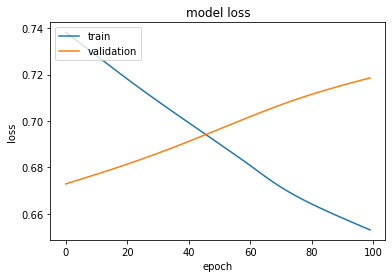

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 421us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[23 33]
 [ 0 11]]
Accuracy :  0.5074626865671642
Sensitivity :  1.0
Specificity :  0.4107142857142857
Precision =  0.25
Recall =  1.0
F1 score =  0.4
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9


In [15]:
results["0"]={}
smote_results["0"]={}
adasyn_results["0"]={}
source=train[train.columns[:-1]]
print(source.shape)


weight_path="weights/wt1.hdf5"
model,callbacks_list=create_model(weight_path,source.shape[1])
target = list(train["Class"])
target=pd.get_dummies(target)
start=time.time()
print("Training MLP")
history = model.fit(source.values, target,epochs=100,validation_split=0.2,callbacks=callbacks_list,verbose=0)
end=time.time()
difference = int(end - start)
print("Time taken to train = ",difference)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

# load weights
model.load_weights(weight_path)
# Compile model (required to make predictions)
opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print("used model and loaded weights from file")

print("Trying MLP")
results["0"]["MLP"]={}
smote_results["0"]["MLP"]={}
adasyn_results["0"]["MLP"]={}

y_actual = list(test["Class"])
y_actual=pd.get_dummies(y_actual)
test_features_only=test[test.columns[:-1]]
_, accuracy = model.evaluate(test_features_only.values, y_actual)
print('Accuracy: %.2f' % (accuracy*100))

y_actual = test["Class"].astype(int)
y_actual=np.asarray(y_actual)
y_predict=model.predict_classes(test_features_only.values)
sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
results["0"]["MLP"]["F1"]=f1_score
results["0"]["MLP"]["sensitivity"]=sensitivity
results["0"]["MLP"]["specificity"]=specificity

smote_results["0"]["MLP"]["F1"]=f1_score  
smote_results["0"]["MLP"]["sensitivity"]=sensitivity
smote_results["0"]["MLP"]["specificity"]=specificity

adasyn_results["0"]["MLP"]["F1"]=f1_score  
adasyn_results["0"]["MLP"]["sensitivity"]=sensitivity
adasyn_results["0"]["MLP"]["specificity"]=specificity


# for other classifiers
target = list(train["Class"])

# Random forest
print("RF")
results["0"]["RF"]={}
smote_results["0"]["RF"]={}
adasyn_results["0"]["RF"]={}

clf=RandomForestClassifier()
clf.fit(source.values,target)
y_pred=None
y_predict=clf.predict(test_features_only.values)
sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
results["0"]["RF"]["F1"]=f1_score
results["0"]["RF"]["sensitivity"]=sensitivity
results["0"]["RF"]["specificity"]=specificity

smote_results["0"]["RF"]["F1"]=f1_score  
smote_results["0"]["RF"]["sensitivity"]=sensitivity
smote_results["0"]["RF"]["specificity"]=specificity

adasyn_results["0"]["RF"]["F1"]=f1_score  
adasyn_results["0"]["RF"]["sensitivity"]=sensitivity
adasyn_results["0"]["RF"]["specificity"]=specificity

#     Gaussian NB
gnb = GaussianNB()
results["0"]["GNB"]={}
smote_results["0"]["GNB"]={}
adasyn_results["0"]["GNB"]={}

print("GNB")
gnb.fit(source.values,target)
y_predict = gnb.predict(test_features_only.values)
sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
results["0"]["GNB"]["F1"]=f1_score
results["0"]["GNB"]["sensitivity"]=sensitivity
results["0"]["GNB"]["specificity"]=specificity

smote_results["0"]["GNB"]["F1"]=f1_score  
smote_results["0"]["GNB"]["sensitivity"]=sensitivity
smote_results["0"]["GNB"]["specificity"]=specificity

adasyn_results["0"]["GNB"]["F1"]=f1_score  
adasyn_results["0"]["GNB"]["sensitivity"]=sensitivity
adasyn_results["0"]["GNB"]["specificity"]=specificity

#     SVM
clf = svm.SVC()
results["0"]["SVM"]={}
smote_results["0"]["SVM"]={}
adasyn_results["0"]["SVM"]={}

print("SVM")
clf.fit(source.values,target)
y_predict=clf.predict(test_features_only.values)
sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
results["0"]["SVM"]["F1"]=f1_score
results["0"]["SVM"]["sensitivity"]=sensitivity
results["0"]["SVM"]["specificity"]=specificity

smote_results["0"]["SVM"]["F1"]=f1_score  
smote_results["0"]["SVM"]["sensitivity"]=sensitivity
smote_results["0"]["SVM"]["specificity"]=specificity

adasyn_results["0"]["SVM"]["F1"]=f1_score  
adasyn_results["0"]["SVM"]["sensitivity"]=sensitivity
adasyn_results["0"]["SVM"]["specificity"]=specificity






In [16]:
results

{'0': {'MLP': {'F1': 0.28205128205128205,
   'sensitivity': 1.0,
   'specificity': 0.0},
  'RF': {'F1': 1.0, 'sensitivity': 1.0, 'specificity': 1.0},
  'GNB': {'F1': 0.4, 'sensitivity': 1.0, 'specificity': 0.4107142857142857},
  'SVM': {'F1': 0.9, 'sensitivity': 0.8181818181818182, 'specificity': 1.0}}}

In [17]:
smote_results

{'0': {'MLP': {'F1': 0.28205128205128205,
   'sensitivity': 1.0,
   'specificity': 0.0},
  'RF': {'F1': 1.0, 'sensitivity': 1.0, 'specificity': 1.0},
  'GNB': {'F1': 0.4, 'sensitivity': 1.0, 'specificity': 0.4107142857142857},
  'SVM': {'F1': 0.9, 'sensitivity': 0.8181818181818182, 'specificity': 1.0}}}

In [18]:
adasyn_results

{'0': {'MLP': {'F1': 0.28205128205128205,
   'sensitivity': 1.0,
   'specificity': 0.0},
  'RF': {'F1': 1.0, 'sensitivity': 1.0, 'specificity': 1.0},
  'GNB': {'F1': 0.4, 'sensitivity': 1.0, 'specificity': 0.4107142857142857},
  'SVM': {'F1': 0.9, 'sensitivity': 0.8181818181818182, 'specificity': 1.0}}}

### With augmentation

randmx =  1
Time taken to augment =  0
329
After augmentation of  60  items with  1  neighbors
0.0    227
1.0    102
Name: Class, dtype: int64
Training model for N =  60  k =  1
Time taken to train =  7


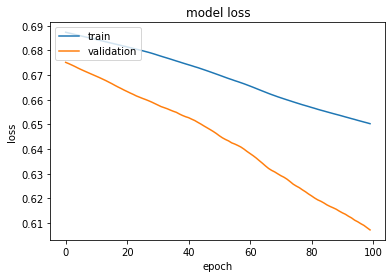

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 385us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[35 21]
 [ 1 10]]
Accuracy :  0.6716417910447762
Sensitivity :  0.9090909090909091
Specificity :  0.625
Precision =  0.3225806451612903
Recall =  0.9090909090909091
F1 score =  0.4761904761904761
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of training  (269, 7)
227 42
0.44933920704845814
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (329, 7)
After OverSampling, the shape of train_y: (329,) 

After OverSampling, counts of label 1: 102
After OverSampling, counts of other label: 227
Training model
Time taken to train =  2


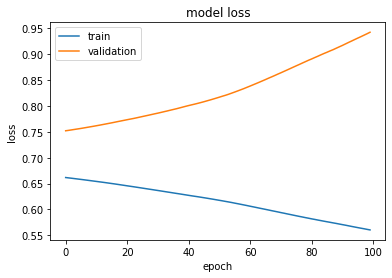

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 386us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[27 29]
 [ 2  9]]
Accuracy :  0.5373134328358209
Sensitivity :  0.8181818181818182
Specificity :  0.48214285714285715
Precision =  0.23684210526315788
Recall =  0.8181818181818182
F1 score =  0.3673469387755102
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.44933920704845814
Time taken to augment by ADASYN =  0
After OverSampling, the shape of train_X: (332, 7)
After OverSampling, the shape of train_y: (332,) 

After OverSampling, counts of label 1: 105
After OverSampling, counts of other label: 227
Training model
Time taken to train =  2


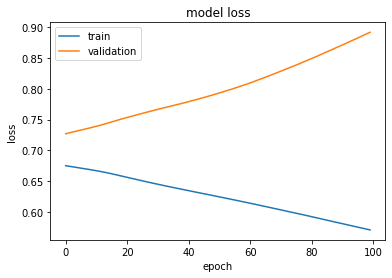

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 390us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 7 49]
 [ 0 11]]
Accuracy :  0.26865671641791045
Sensitivity :  1.0
Specificity :  0.125
Precision =  0.18333333333333332
Recall =  1.0
F1 score =  0.30985915492957744
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
randmx =  1


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Time taken to augment =  0
329
After augmentation of  60  items with  2  neighbors
0.0    227
1.0    102
Name: Class, dtype: int64
Training model for N =  60  k =  2
Time taken to train =  7


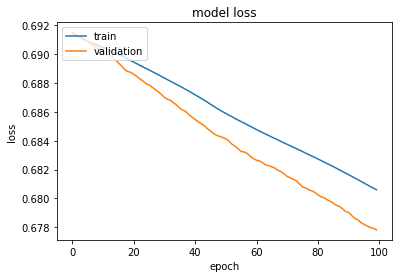

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 375us/step
Accuracy: 88.06
Confusion Matrix : 
 [[53  3]
 [ 5  6]]
Accuracy :  0.8805970149253731
Sensitivity :  0.5454545454545454
Specificity :  0.9464285714285714
Precision =  0.6666666666666666
Recall =  0.5454545454545454
F1 score =  0.6
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[38 18]
 [ 2  9]]
Accuracy :  0.7014925373134329
Sensitivity :  0.8181818181818182
Specificity :  0.6785714285714286
Precision =  0.3333333333333333
Recall =  0.8181818181818182
F1 score =  0.4736842105263157
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
S

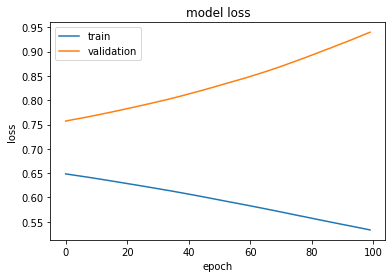

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 379us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[25 31]
 [ 1 10]]
Accuracy :  0.5223880597014925
Sensitivity :  0.9090909090909091
Specificity :  0.44642857142857145
Precision =  0.24390243902439024
Recall =  0.9090909090909091
F1 score =  0.38461538461538464
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.44933920704845814
Time taken to augment by ADASYN =  0
After OverSampling, the sh

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Training model
Time taken to train =  2


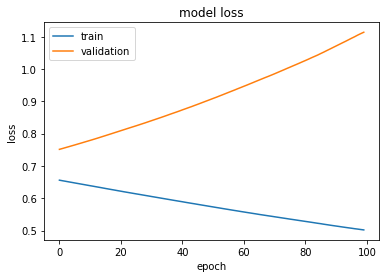

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 427us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 8 48]
 [ 0 11]]
Accuracy :  0.2835820895522388
Sensitivity :  1.0
Specificity :  0.14285714285714285
Precision =  0.1864406779661017
Recall =  1.0
F1 score =  0.3142857142857143
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
randmx =  1


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Time taken to augment =  0
329
After augmentation of  60  items with  5  neighbors
0.0    227
1.0    102
Name: Class, dtype: int64
Training model for N =  60  k =  5
Time taken to train =  8


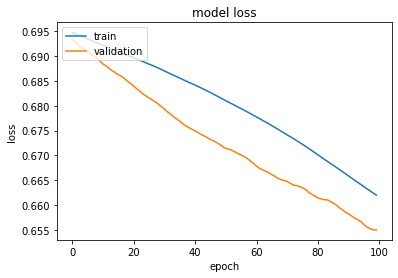

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 442us/step
Accuracy: 92.54
Confusion Matrix : 
 [[54  2]
 [ 3  8]]
Accuracy :  0.9253731343283582
Sensitivity :  0.7272727272727273
Specificity :  0.9642857142857143
Precision =  0.8
Recall =  0.7272727272727273
F1 score =  0.761904761904762
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[45 11]
 [ 2  9]]
Accuracy :  0.8059701492537313
Sensitivity :  0.8181818181818182
Specificity :  0.8035714285714286
Precision =  0.45
Recall =  0.8181818181818182
F1 score =  0.5806451612903226
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of trainin

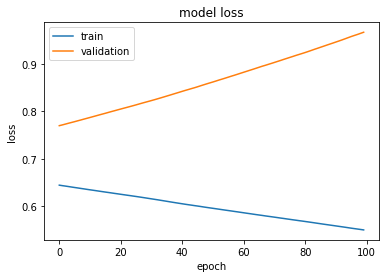

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 374us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34 22]
 [ 2  9]]
Accuracy :  0.6417910447761194
Sensitivity :  0.8181818181818182
Specificity :  0.6071428571428571
Precision =  0.2903225806451613
Recall =  0.8181818181818182
F1 score =  0.4285714285714286
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.44933920704845814
Time taken to augment by ADASYN =  0
After OverSampling, the shape

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Training model
Time taken to train =  2


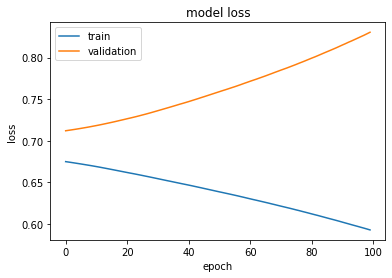

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 377us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[14 42]
 [ 0 11]]
Accuracy :  0.373134328358209
Sensitivity :  1.0
Specificity :  0.25
Precision =  0.20754716981132076
Recall =  1.0
F1 score =  0.34375000000000006
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
randmx =  1


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Time taken to augment =  0
329
After augmentation of  60  items with  10  neighbors
0.0    227
1.0    102
Name: Class, dtype: int64
Training model for N =  60  k =  10
Time taken to train =  8


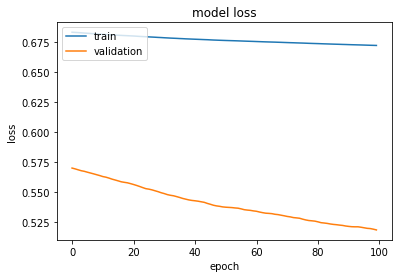

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 372us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[47  9]
 [ 2  9]]
Accuracy :  0.835820895522388
Sensitivity :  0.8181818181818182
Specificity :  0.8392857142857143
Precision =  0.5
Recall =  0.8181818181818182
F1 score =  0.6206896551724137
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of training  (269, 7)
227 42
0.44933920704845814
Time taken to augment b

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Training model
Time taken to train =  2


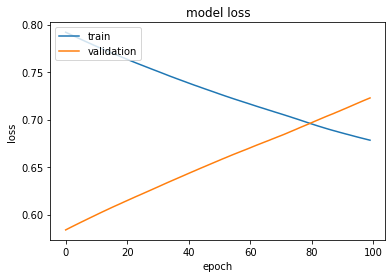

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 374us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[35 21]
 [ 2  9]]
Accuracy :  0.6567164179104478
Sensitivity :  0.8181818181818182
Specificity :  0.625
Precision =  0.3
Recall =  0.8181818181818182
F1 score =  0.43902439024390244
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.44933920704845814
Time taken to augment by ADASYN =  0
After OverSampling, th

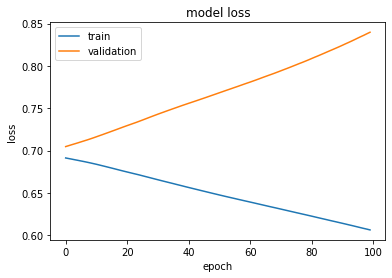

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 395us/step
Accuracy: 61.19
Confusion Matrix : 
 [[40 16]
 [10  1]]
Accuracy :  0.6119402985074627
Sensitivity :  0.09090909090909091
Specificity :  0.7142857142857143
Precision =  0.058823529411764705
Recall =  0.09090909090909091
F1 score =  0.07142857142857142
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[16 40]
 [ 0 11]]
Accuracy :  0.40298507462686567
Sensitivity :  1.0
Specificity :  0.2857142857142857
Precision =  0.21568627450980393
Recall =  1.0
F1 score =  0.3548387096774193
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
randmx =  1
Time taken to augment =  0
389
After augmentation of  120  

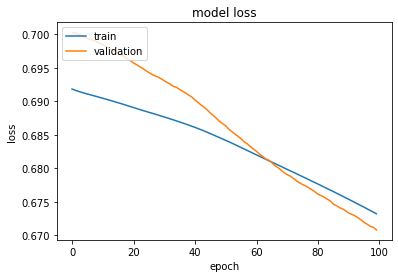

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 376us/step
Accuracy: 89.55
Confusion Matrix : 
 [[51  5]
 [ 2  9]]
Accuracy :  0.8955223880597015
Sensitivity :  0.8181818181818182
Specificity :  0.9107142857142857
Precision =  0.6428571428571429
Recall =  0.8181818181818182
F1 score =  0.7200000000000001
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[26 30]
 [ 2  9]]
Accuracy :  0.5223880597014925
Sensitivity :  0.8181818181818182
Specificity :  0.4642857142857143
Precision =  0.23076923076923078
Recall =  0.8181818181818182
F1 score =  0.36000000000000004
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting S

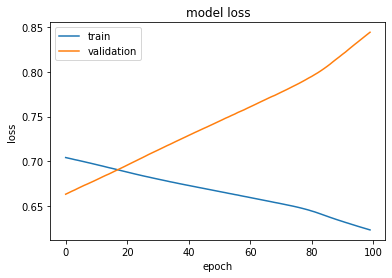

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 370us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[25 31]
 [ 1 10]]
Accuracy :  0.5223880597014925
Sensitivity :  0.9090909090909091
Specificity :  0.44642857142857145
Precision =  0.24390243902439024
Recall =  0.9090909090909091
F1 score =  0.38461538461538464
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.7136563876651982


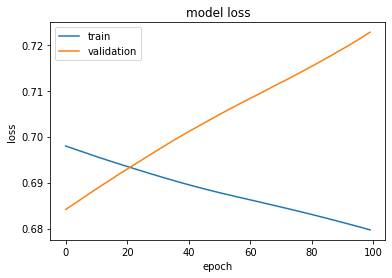

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 380us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 6 50]
 [ 0 11]]
Accuracy :  0.2537313432835821
Sensitivity :  1.0
Specificity :  0.10714285714285714
Precision =  0.18032786885245902
Recall =  1.0
F1 score =  0.3055555555555556
SVM
Confusion Matrix : 
 [[55  1]
 [ 1 10]]
Accuracy :  0.9701492537313433
Sensitivity :  0.9090909090909091
Specificity :  0.9821428571428571
Precision =  0.9090909090909091
Recall =  0.9090909090909091
F1 score =  0.9090909090909091
randmx =  1
Time taken to augment =  0
389
After augmentation of  120  items with  2  neighbors
0.0    

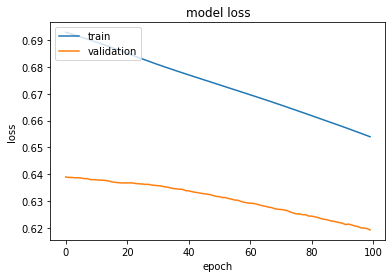

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 415us/step
Accuracy: 95.52
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[43 13]
 [ 2  9]]
Accuracy :  0.7761194029850746
Sensitivity :  0.8181818181818182
Specificity :  0.7678571428571429
Precision =  0.4090909090909091
Recall =  0.8181818181818182
F1 score =  0.5454545454545455
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
S

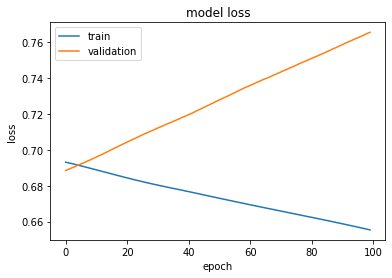

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 389us/step
Accuracy: 38.81
Confusion Matrix : 
 [[16 40]
 [ 1 10]]
Accuracy :  0.3880597014925373
Sensitivity :  0.9090909090909091
Specificity :  0.2857142857142857
Precision =  0.2
Recall =  0.9090909090909091
F1 score =  0.32786885245901637
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[24 32]
 [ 1 10]]
Accuracy :  0.5074626865671642
Sensitivity :  0.9090909090909091
Specificity :  0.42857142857142855
Precision =  0.23809523809523808
Recall =  0.9090909090909091
F1 score =  0.3773584905660377
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.7136563876651982
Tim

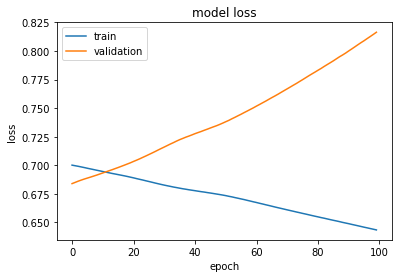

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 388us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 7 49]
 [ 0 11]]
Accuracy :  0.26865671641791045
Sensitivity :  1.0
Specificity :  0.125
Precision =  0.18333333333333332
Recall =  1.0
F1 score =  0.30985915492957744
SVM
Confusion Matrix : 
 [[53  3]
 [ 1 10]]
Accuracy :  0.9402985074626866
Sensitivity :  0.9090909090909091
Specificity :  0.9464285714285714
Precision =  0.7692307692307693
Recall =  0.9090909090909091
F1 score =  0.8333333333333333
randmx =  1
Time taken to augment =  0
389
After augmentation of  120  items with  5  neighbors
0.0    227
1.0    1

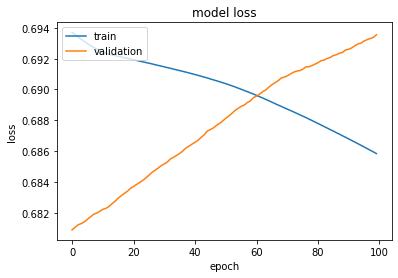

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 376us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[48  8]
 [ 2  9]]
Accuracy :  0.8507462686567164
Sensitivity :  0.8181818181818182
Specificity :  0.8571428571428571
Precision =  0.5294117647058824
Recall =  0.8181818181818182
F1 score =  0.6428571428571428
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of training  (269, 7)
227 42
0.7136563876651982
Time tak

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Training model
Time taken to train =  2


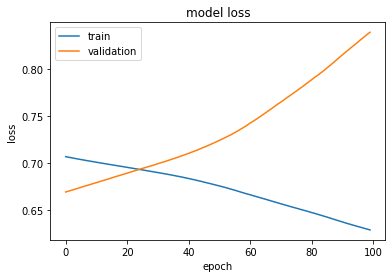

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 425us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[41 15]
 [ 2  9]]
Accuracy :  0.746268656716418
Sensitivity :  0.8181818181818182
Specificity :  0.7321428571428571
Precision =  0.375
Recall =  0.8181818181818182
F1 score =  0.5142857142857142
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.7136563876651982
Time taken to aug

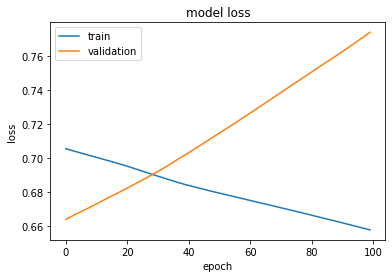

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 422us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 5 51]
 [ 0 11]]
Accuracy :  0.23880597014925373
Sensitivity :  1.0
Specificity :  0.08928571428571429
Precision =  0.1774193548387097
Recall =  1.0
F1 score =  0.3013698630136986
SVM
Confusion Matrix : 
 [[53  3]
 [ 1 10]]
Accuracy :  0.9402985074626866
Sensitivity :  0.9090909090909091
Specificity :  0.9464285714285714
Precision =  0.7692307692307693
Recall =  0.9090909090909091
F1 score =  0.8333333333333333
randmx =  1
Time taken to augment =  0
389
After augmentation of  120  items with  10  neighbors
0.0   

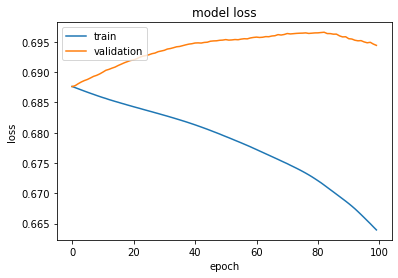

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 389us/step
Accuracy: 94.03
Confusion Matrix : 
 [[54  2]
 [ 2  9]]
Accuracy :  0.9402985074626866
Sensitivity :  0.8181818181818182
Specificity :  0.9642857142857143
Precision =  0.8181818181818182
Recall =  0.8181818181818182
F1 score =  0.8181818181818182
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[49  7]
 [ 2  9]]
Accuracy :  0.8656716417910447
Sensitivity :  0.8181818181818182
Specificity :  0.875
Precision =  0.5625
Recall =  0.8181818181818182
F1 score =  0.6666666666666666
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of tr

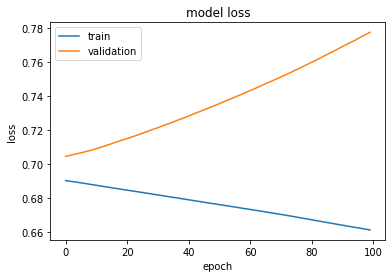

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 370us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34 22]
 [ 2  9]]
Accuracy :  0.6417910447761194
Sensitivity :  0.8181818181818182
Specificity :  0.6071428571428571
Precision =  0.2903225806451613
Recall =  0.8181818181818182
F1 score =  0.4285714285714286
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.7136563876651982


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Time taken to augment by ADASYN =  0
After OverSampling, the shape of train_X: (385, 7)
After OverSampling, the shape of train_y: (385,) 

After OverSampling, counts of label 1: 158
After OverSampling, counts of other label: 227
Training model
Time taken to train =  2


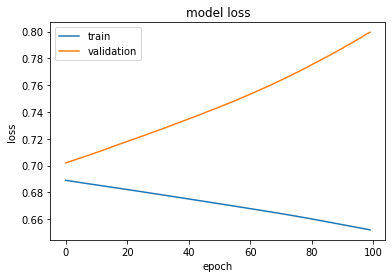

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 379us/step
Accuracy: 82.09
Confusion Matrix : 
 [[55  1]
 [11  0]]
Accuracy :  0.8208955223880597
Sensitivity :  0.0
Specificity :  0.9821428571428571
Precision =  0.0
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 8 48]
 [ 0 11]]
Accuracy :  0.2835820895522388
Sensitivity :  1.0
Specificity :  0.14285714285714285
Precision =  0.1864406779661017
Recall =  1.0
F1 score =  0.3142857142857143
SVM
Confusion Matrix : 
 [[54  2]
 [ 1 10]]
Accuracy :  0.9552238805970149
Sensitivity :  0.9090909090909091
Specificity :  0.9642857142857143
Precision =  0.8333333333333334
Recall =  0.9090909090909091
F1 score =  0.8695652173913043
randmx =  1


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


Time taken to augment =  0
449
After augmentation of  180  items with  1  neighbors
0.0    227
1.0    222
Name: Class, dtype: int64
Training model for N =  180  k =  1
Time taken to train =  2


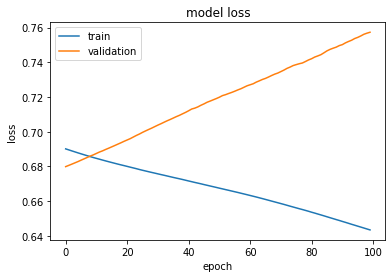

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 381us/step
Accuracy: 64.18
Confusion Matrix : 
 [[34 22]
 [ 2  9]]
Accuracy :  0.6417910447761194
Sensitivity :  0.8181818181818182
Specificity :  0.6071428571428571
Precision =  0.2903225806451613
Recall =  0.8181818181818182
F1 score =  0.4285714285714286
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[31 25]
 [ 2  9]]
Accuracy :  0.5970149253731343
Sensitivity :  0.8181818181818182
Specificity :  0.5535714285714286
Precision =  0.2647058823529412
Recall =  0.8181818181818182
F1 score =  0.39999999999999997
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571

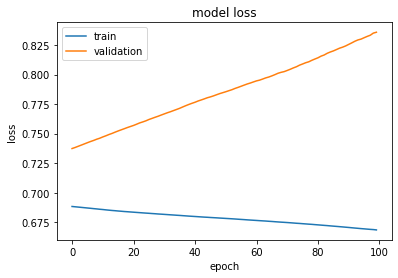

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 370us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[26 30]
 [ 1 10]]
Accuracy :  0.5373134328358209
Sensitivity :  0.9090909090909091
Specificity :  0.4642857142857143
Precision =  0.25
Recall =  0.9090909090909091
F1 score =  0.392156862745098
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.9779735682819384


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Time taken to augment by ADASYN =  0
After OverSampling, the shape of train_X: (449, 7)
After OverSampling, the shape of train_y: (449,) 

After OverSampling, counts of label 1: 222
After OverSampling, counts of other label: 227
Training model
Time taken to train =  3


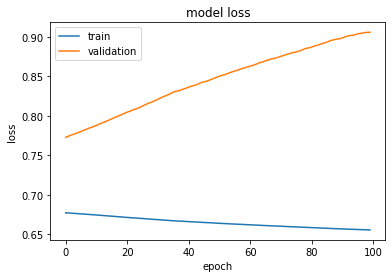

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 394us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 6 50]
 [ 0 11]]
Accuracy :  0.2537313432835821
Sensitivity :  1.0
Specificity :  0.10714285714285714
Precision =  0.18032786885245902
Recall =  1.0
F1 score =  0.3055555555555556
SVM


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[51  5]
 [ 0 11]]
Accuracy :  0.9253731343283582
Sensitivity :  1.0
Specificity :  0.9107142857142857
Precision =  0.6875
Recall =  1.0
F1 score =  0.8148148148148148
randmx =  1
Time taken to augment =  0
449
After augmentation of  180  items with  2  neighbors
0.0    227
1.0    222
Name: Class, dtype: int64
Training model for N =  180  k =  2
Time taken to train =  2


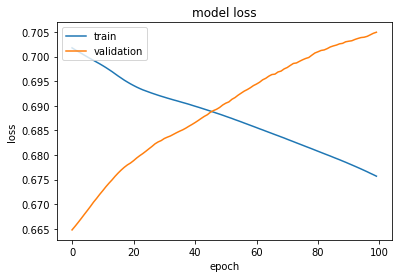

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 372us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[44 12]
 [ 2  9]]
Accuracy :  0.7910447761194029
Sensitivity :  0.8181818181818182
Specificity :  0.7857142857142857
Precision =  0.42857142857142855
Recall =  0.8181818181818182
F1 score =  0.5625
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of training  (269, 7)
227 42
0.9779735682819384
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (449, 7)
After OverSampling, the shape of train_y: (449,) 

After OverSampling, counts of label 1: 222
After OverSampling, counts of other label: 227
Training model
Time taken to train =  3


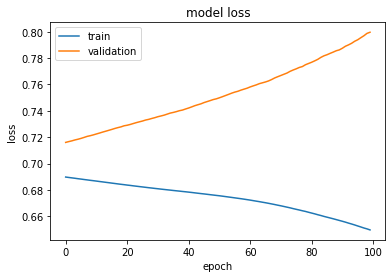

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 391us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[30 26]
 [ 2  9]]
Accuracy :  0.582089552238806
Sensitivity :  0.8181818181818182
Specificity :  0.5357142857142857
Precision =  0.2571428571428571
Recall =  0.8181818181818182
F1 score =  0.39130434782608686
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.9779735682819384
Time taken to augment by ADASYN =  0
After OverSampling, the shape of train_X: (452, 7)
After OverSampling, the shape of train_y: (452,) 

After OverSampling, counts of label 1: 225
After OverSampling, counts of other label: 227
Training model
Time taken to train =  2


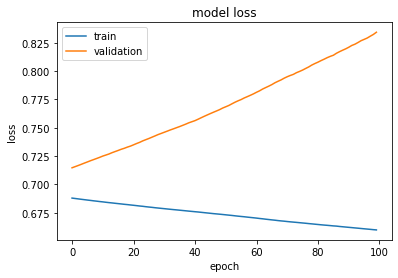

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 384us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 1 55]
 [ 0 11]]
Accuracy :  0.1791044776119403
Sensitivity :  1.0
Specificity :  0.017857142857142856
Precision =  0.16666666666666666
Recall =  1.0
F1 score =  0.2857142857142857
SVM
Confusion Matrix : 
 [[52  4]
 [ 0 11]]
Accuracy :  0.9402985074626866
Sensitivity :  1.0
Specificity :  0.9285714285714286
Precision =  0.7333333333333333
Recall =  1.0
F1 score =  0.846153846153846
randmx =  1
Time taken to augment =  0
449
After augmentation of  180  items with  5  neighbors
0.0    227
1.0    222
Name: Class, dtype: int64
Training model for N =  180  k =  5
Time taken to train =  2


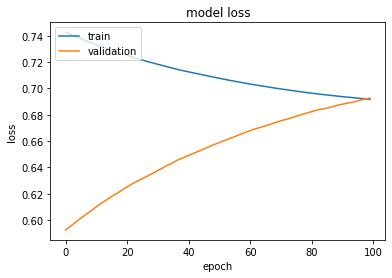

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 380us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[49  7]
 [ 2  9]]
Accuracy :  0.8656716417910447
Sensitivity :  0.8181818181818182
Specificity :  0.875
Precision =  0.5625
Recall =  0.8181818181818182
F1 score =  0.6666666666666666
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of training  (269, 7)
227 42
0.9779735682819384
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (449, 7)
After OverSampling, the shape of train_y: (449,) 

After OverSampling, counts of label 1: 222
After OverSampling, counts of other label: 227
Training model
Time taken to train =  3


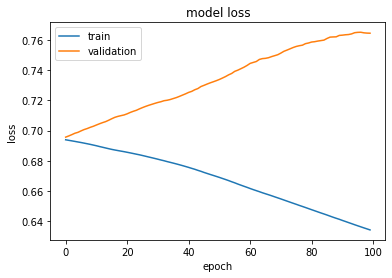

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 398us/step
Accuracy: 49.25
Confusion Matrix : 
 [[32 24]
 [10  1]]
Accuracy :  0.4925373134328358
Sensitivity :  0.09090909090909091
Specificity :  0.5714285714285714
Precision =  0.04
Recall =  0.09090909090909091
F1 score =  0.05555555555555555
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[38 18]
 [ 2  9]]
Accuracy :  0.7014925373134329
Sensitivity :  0.8181818181818182
Specificity :  0.6785714285714286
Precision =  0.3333333333333333
Recall =  0.8181818181818182
F1 score =  0.4736842105263157
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
******Starting ADASYN***********
Shape of training  (269, 7

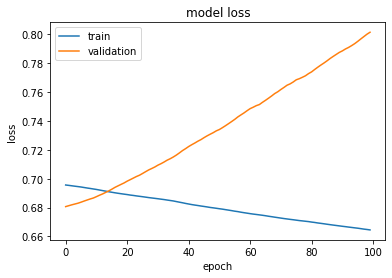

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 413us/step
Accuracy: 17.91
Confusion Matrix : 
 [[ 1 55]
 [ 0 11]]
Accuracy :  0.1791044776119403
Sensitivity :  1.0
Specificity :  0.017857142857142856
Precision =  0.16666666666666666
Recall =  1.0
F1 score =  0.2857142857142857
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[ 9 47]
 [ 0 11]]
Accuracy :  0.29850746268656714
Sensitivity :  1.0
Specificity :  0.16071428571428573
Precision =  0.1896551724137931
Recall =  1.0
F1 score =  0.3188405797101449
SVM
Confusion Matrix : 
 [[52  4]
 [ 0 11]]
Accuracy :  0.9402985074626866
Sensitivity :  1.0
Specificity :  0.9285714285714286
Precision =  0.7333333333333333
Recall =  1.0
F1 score =  0.846153846153846
randmx =  1
Time taken to augment =  0
449
After augmentation of  180  items with  10  neighbors
0.0    227
1.0    222


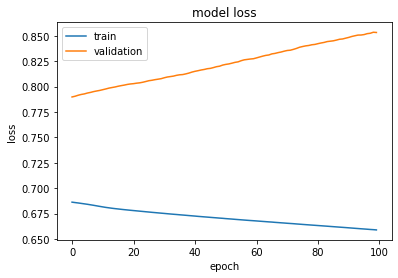

used model and loaded weights from file
Test distribution
0    56
1    11
Name: Class, dtype: int64
Trying MLP
67/67 [==============================] - 0s 381us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[49  7]
 [ 2  9]]
Accuracy :  0.8656716417910447
Sensitivity :  0.8181818181818182
Specificity :  0.875
Precision =  0.5625
Recall =  0.8181818181818182
F1 score =  0.6666666666666666
SVM
Confusion Matrix : 
 [[56  0]
 [ 2  9]]
Accuracy :  0.9701492537313433
Sensitivity :  0.8181818181818182
Specificity :  1.0
Precision =  1.0
Recall =  0.8181818181818182
F1 score =  0.9
******Starting SMOTE***********
Shape of training  (269, 7)
227 42
0.9779735682819384

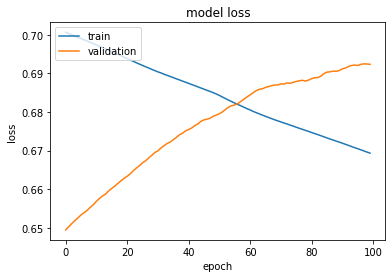

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 382us/step
Accuracy: 16.42
Confusion Matrix : 
 [[ 0 56]
 [ 0 11]]
Accuracy :  0.16417910447761194
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.16417910447761194
Recall =  1.0
F1 score =  0.28205128205128205
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34 22]
 [ 2  9]]
Accuracy :  0.6417910447761194
Sensitivity :  0.8181818181818182
Specificity :  0.6071428571428571
Precision =  0.2903225806451613
Recall =  0.8181818181818182
F1 score =  0.4285714285714286
SVM
Confusion Matrix : 
 [[55  1]
 [ 2  9]]
Accuracy :  0.9552238805970149
Sensitivity :  0.8181818181818182
Specificity :  0.9821428571428571
Precision =  0.9
Recall =  0.8181818181818182
F1 score =  0.8571428571428572
******Starting ADASYN***********
Shape of training  (269, 7)
227 42
0.9779735682819384
Tim

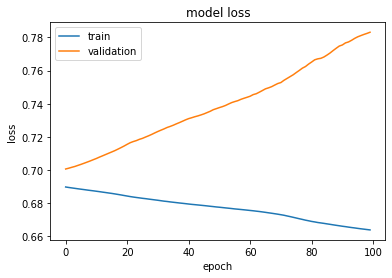

used model and loaded weights from file
Trying MLP
67/67 [==============================] - 0s 380us/step
Accuracy: 83.58
Confusion Matrix : 
 [[56  0]
 [11  0]]
Accuracy :  0.835820895522388
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[56  0]
 [ 0 11]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[11 45]
 [ 0 11]]
Accuracy :  0.3283582089552239
Sensitivity :  1.0
Specificity :  0.19642857142857142
Precision =  0.19642857142857142
Recall =  1.0
F1 score =  0.3283582089552239
SVM
Confusion Matrix : 
 [[54  2]
 [ 1 10]]
Accuracy :  0.9552238805970149
Sensitivity :  0.9090909090909091
Specificity :  0.9642857142857143
Precision =  0.8333333333333334
Recall =  0.9090909090909091
F1 score =  0.8695652173913043


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
N_range=[60,120,180]
for N in N_range:
    results[N]={}
    smote_results[N]={}
    adasyn_results[N]={}
    
    k_range=[1,2,5,10]
    for k in k_range:
        results[N][k]={}
        smote_results[N][k]={}  
        adasyn_results[N][k]={}
        
        results[N][k]["MLP"]={}
        smote_results[N][k]["MLP"]={}  
        adasyn_results[N][k]["MLP"]={}

        results[N][k]["RF"]={}
        smote_results[N][k]["RF"]={}  
        adasyn_results[N][k]["RF"]={}
        
        results[N][k]["GNB"]={}
        smote_results[N][k]["GNB"]={}  
        adasyn_results[N][k]["GNB"]={}

        results[N][k]["SVM"]={}
        smote_results[N][k]["SVM"]={}  
        adasyn_results[N][k]["SVM"]={}


        class_index=1
        randmx=1
        dist_percent=0.9

        
        daug = data_augment.DataAugment()
        print("randmx = ",randmx)
        now = time.time()
        [Data_a,Ext_d,Ext_not]=daug.augment(data=train.values,k=k,class_ind=class_index,N=N,
                                            randmx=randmx,dist_percent=dist_percent)
        later = time.time()
        difference = int(later - now)
        print("Time taken to augment = ",difference)
        print(len(Data_a))

        train_aug=pd.DataFrame(data=Data_a,index=None,    # values                
                columns=columns)      

        print("After augmentation of ",N," items with ",k," neighbors")

        print(train_aug["Class"].value_counts())
        source=train_aug[train_aug.columns[:-1]]
        target = list(train_aug["Class"])
        target=pd.get_dummies(target)

        weight_path="weights/"+str(N)+"_"+str(k)+"_wt1.hdf5"    
        model,callbacks_list=create_model(weight_path,source.shape[1])
        start=time.time()
        print("Training model for N = ",N," k = ",k)
        history = model.fit(source.values, target,epochs=100,validation_split=0.2,callbacks=callbacks_list,verbose=0)
        end=time.time()
        difference = int(end - start)
        print("Time taken to train = ",difference)



        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show()    

        # load weights
        model.load_weights(weight_path)
        # Compile model (required to make predictions)
        opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        print("used model and loaded weights from file")    
        print("Test distribution")
        print(test["Class"].value_counts())
        print("Trying MLP")
        y_actual = list(test["Class"])
        y_actual=pd.get_dummies(y_actual)
        test_features_only=test[test.columns[:-1]]
        _, accuracy = model.evaluate(test_features_only.values, y_actual)
        print('Accuracy: %.2f' % (accuracy*100))            


        y_actual = test["Class"].astype(int)
        y_actual=np.asarray(y_actual)
        y_predict=model.predict_classes(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        results[N][k]["MLP"]["F1"]=f1_score 
        results[N][k]["MLP"]["sensitivity"]=sensitivity 
        results[N][k]["MLP"]["specificity"]=specificity         
        


        # for other classifiers
        target = list(train_aug["Class"])
        source=train_aug[train_aug.columns[:-1]]
        test_features_only=test[test.columns[:-1]]

        # Random forest
        print("RF")
        clf=RandomForestClassifier()
        clf.fit(source.values,target)
        y_predict=clf.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        results[N][k]["RF"]["F1"]=f1_score 
        results[N][k]["RF"]["sensitivity"]=sensitivity 
        results[N][k]["RF"]["specificity"]=specificity         
                

    #     Gaussian NB
        print("GNB")
        gnb = GaussianNB()
        gnb.fit(source.values,target)
        y_predict = gnb.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        results[N][k]["GNB"]["F1"]=f1_score 
        results[N][k]["GNB"]["sensitivity"]=sensitivity 
        results[N][k]["GNB"]["specificity"]=specificity         
                        
        

    #     SVM
        print("SVM")
        clf = svm.SVC()
        clf.fit(source.values,target)
        y_predict=clf.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        results[N][k]["SVM"]["F1"]=f1_score 
        results[N][k]["SVM"]["sensitivity"]=sensitivity 
        results[N][k]["SVM"]["specificity"]=specificity         
                                
        
        
        
        # this part for SMOTE
        print("******Starting SMOTE***********")
        source=train[train.columns[:-1]]
        print("Shape of training ",source.shape)

        y_train=train["Class"].values
        num_minority=sum(y_train==class_index)
        num_majority=len(y_train)-num_minority
        print(num_majority,num_minority)
        
        samp_strategy=(num_minority+N)/num_majority
        print(samp_strategy)
        now = time.time()
        sm = SMOTE(random_state=2,k_neighbors=k,sampling_strategy=samp_strategy)
        X_train_res, y_train_res = sm.fit_sample(source, y_train.ravel())
        source=X_train_res

        later = time.time()
        difference = int(later - now)
        print("Time taken to augment by SMOTE = ",difference)

        print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
        print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

        print("After OverSampling, counts of label {}: {}".format(class_index,sum(y_train_res==1)))
        print("After OverSampling, counts of other label: {}".format(len(y_train_res)-sum(y_train_res==class_index)))  
        
        weight_path="weights/smote"+"_"+str(N)+"_"+str(k)+"_wt1.hdf5"    
        model,callbacks_list=create_model(weight_path,X_train_res.shape[1])
        start=time.time()
        print("Training model")
        target=pd.get_dummies(y_train_res)
        history = model.fit(X_train_res.values, target,epochs=100,validation_split=0.2,callbacks=callbacks_list,verbose=0)
        end=time.time()
        difference = int(end - start)
        print("Time taken to train = ",difference) 

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show()

        

        # load weights
        model.load_weights(weight_path)
        # Compile model (required to make predictions)
        opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        print("used model and loaded weights from file")    
        print("Trying MLP")
        y_actual = list(test["Class"])
        y_actual=pd.get_dummies(y_actual)
        test_features_only=test[test.columns[:-1]]
        _, accuracy = model.evaluate(test_features_only.values, y_actual)
        print('Accuracy: %.2f' % (accuracy*100)) 



        y_actual = test["Class"].astype(int)
        y_actual=np.asarray(y_actual)
        y_predict=model.predict_classes(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        smote_results[N][k]["MLP"]["F1"]=f1_score         
        smote_results[N][k]["MLP"]["sensitivity"]=sensitivity                 
        smote_results[N][k]["MLP"]["specificity"]=specificity                 

        # for other classifiers
        target = y_train_res
        source=X_train_res
        test_features_only=test[test.columns[:-1]]

        # Random forest
        print("RF")
        clf=RandomForestClassifier()
        clf.fit(source.values,target)
        y_predict=clf.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        smote_results[N][k]["RF"]["F1"]=f1_score         
        smote_results[N][k]["RF"]["sensitivity"]=sensitivity                 
        smote_results[N][k]["RF"]["specificity"]=specificity

    #     Gaussian NB
        print("GNB")
        gnb = GaussianNB()
        gnb.fit(source.values,target)
        y_predict = gnb.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        smote_results[N][k]["GNB"]["F1"]=f1_score         
        smote_results[N][k]["GNB"]["sensitivity"]=sensitivity                 
        smote_results[N][k]["GNB"]["specificity"]=specificity

    #     SVM
        print("SVM")
        clf = svm.SVC()
        clf.fit(source.values,target)
        y_predict=clf.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        smote_results[N][k]["SVM"]["F1"]=f1_score         
        smote_results[N][k]["SVM"]["sensitivity"]=sensitivity                 
        smote_results[N][k]["SVM"]["specificity"]=specificity

        
        
        
        
        # this part for ADASYN
        print("******Starting ADASYN***********")
        source=train[train.columns[:-1]]
        print("Shape of training ",source.shape)

        y_train=train["Class"].values
        num_minority=sum(y_train==class_index)
        num_majority=len(y_train)-num_minority
        print(num_majority,num_minority)
        
        samp_strategy=(num_minority+N)/num_majority
        print(samp_strategy)
        now = time.time()
        ad = ADASYN(random_state=2,n_neighbors=k,sampling_strategy=samp_strategy)
        X_train_res, y_train_res = ad.fit_sample(source, y_train.ravel())
        source=X_train_res

        later = time.time()
        difference = int(later - now)
        print("Time taken to augment by ADASYN = ",difference)

        print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
        print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

        print("After OverSampling, counts of label {}: {}".format(class_index,sum(y_train_res==1)))
        print("After OverSampling, counts of other label: {}".format(len(y_train_res)-sum(y_train_res==class_index)))  
        
        weight_path="weights/adasyn"+"_"+str(N)+"_"+str(k)+"_wt1.hdf5"    
        model,callbacks_list=create_model(weight_path,X_train_res.shape[1])
        start=time.time()
        print("Training model")
        target=pd.get_dummies(y_train_res)
        history = model.fit(X_train_res.values, target,epochs=100,validation_split=0.2,callbacks=callbacks_list,verbose=0)
        end=time.time()
        difference = int(end - start)
        print("Time taken to train = ",difference) 

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show()

        

        # load weights
        model.load_weights(weight_path)
        # Compile model (required to make predictions)
        opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        print("used model and loaded weights from file")    
        print("Trying MLP")
        y_actual = list(test["Class"])
        y_actual=pd.get_dummies(y_actual)
        test_features_only=test[test.columns[:-1]]
        _, accuracy = model.evaluate(test_features_only.values, y_actual)
        print('Accuracy: %.2f' % (accuracy*100)) 



        y_actual = test["Class"].astype(int)
        y_actual=np.asarray(y_actual)
        y_predict=model.predict_classes(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        adasyn_results[N][k]["MLP"]["F1"]=f1_score         
        adasyn_results[N][k]["MLP"]["sensitivity"]=sensitivity                 
        adasyn_results[N][k]["MLP"]["specificity"]=specificity

        # for other classifiers
        target = y_train_res
        source=X_train_res
        test_features_only=test[test.columns[:-1]]

        # Random forest
        print("RF")
        clf=RandomForestClassifier()
        clf.fit(source.values,target)
        y_predict=clf.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        adasyn_results[N][k]["RF"]["F1"]=f1_score         
        adasyn_results[N][k]["RF"]["sensitivity"]=sensitivity                 
        adasyn_results[N][k]["RF"]["specificity"]=specificity

    #     Gaussian NB
        print("GNB")
        gnb = GaussianNB()
        gnb.fit(source.values,target)
        y_predict = gnb.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        adasyn_results[N][k]["GNB"]["F1"]=f1_score         
        adasyn_results[N][k]["GNB"]["sensitivity"]=sensitivity                 
        adasyn_results[N][k]["GNB"]["specificity"]=specificity

    #     SVM
        print("SVM")
        clf = svm.SVC()
        clf.fit(source.values,target)
        y_predict=clf.predict(test_features_only.values)
        sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
        adasyn_results[N][k]["SVM"]["F1"]=f1_score         
        adasyn_results[N][k]["SVM"]["sensitivity"]=sensitivity                 
        adasyn_results[N][k]["SVM"]["specificity"]=specificity        
        
        
        



        


In [20]:
# get best

print("randmx = ",randmx)
print("dist_percent = ",dist_percent)
import math
checks=["MLP","RF","GNB","SVM"]
# checks=["GNB"]

best_n=None
best_k=None
best_sensitivity=0
best_specificity=0
best_f1=0

print("KNNOR")


for check in checks:
    for k,v in results.items():
        if k=="0":
            continue
        for k1,v1 in v.items():
#             print(k1)
#             print(v1)
            if math.isnan(v1[check]["F1"]):
                continue
#             print(v1[check]["F1"])
            if best_f1<v1[check]["F1"]:
                best_f1=v1[check]["F1"]
                best_n=k
                best_k=k1
                best_sensitivity=v1[check]["sensitivity"]
                best_specificity=v1[check]["specificity"]
                

    print(check,best_f1,"[N=",best_n,",k=",best_k,"]")
    print("Sensitivity = ",best_sensitivity)
    print("Specificity = ",best_specificity)    
    
    best_f1=0
    best_k=None
    best_n=None
    best_sensitivity=0
    best_specificity=0



randmx =  1
dist_percent =  0.9
KNNOR
MLP 0.8571428571428572 [N= 120 ,k= 2 ]
Sensitivity =  0.8181818181818182
Specificity =  0.9821428571428571
RF 1.0 [N= 60 ,k= 1 ]
Sensitivity =  1.0
Specificity =  1.0
GNB 0.6666666666666666 [N= 120 ,k= 10 ]
Sensitivity =  0.8181818181818182
Specificity =  0.875
SVM 0.9 [N= 60 ,k= 1 ]
Sensitivity =  0.8181818181818182
Specificity =  1.0


In [21]:
# get best

print("randmx = ",randmx)
print("dist_percent = ",dist_percent)
import math
checks=["MLP","RF","GNB","SVM"]
# checks=["GNB"]

best_n=None
best_k=None
best_sensitivity=0
best_specificity=0
best_f1=0

print("SMOTE")


for check in checks:
    for k,v in smote_results.items():
        if k=="0":
            continue
        for k1,v1 in v.items():
#             print(k1)
#             print(v1)
            if math.isnan(v1[check]["F1"]):
                continue
#             print(v1[check]["F1"])
            if best_f1<v1[check]["F1"]:
                best_f1=v1[check]["F1"]
                best_n=k
                best_k=k1
                best_sensitivity=v1[check]["sensitivity"]
                best_specificity=v1[check]["specificity"]                

    print(check,best_f1,"[N=",best_n,",k=",best_k,"]")
    print("Sensitivity = ",best_sensitivity)
    print("Specificity = ",best_specificity)
    
    best_f1=0
    best_k=None
    best_n=None
    best_sensitivity=0
    best_specificity=0
    



randmx =  1
dist_percent =  0.9
SMOTE
MLP 0.32786885245901637 [N= 120 ,k= 2 ]
Sensitivity =  0.9090909090909091
Specificity =  0.2857142857142857
RF 1.0 [N= 60 ,k= 1 ]
Sensitivity =  1.0
Specificity =  1.0
GNB 0.5142857142857142 [N= 120 ,k= 5 ]
Sensitivity =  0.8181818181818182
Specificity =  0.7321428571428571
SVM 0.9 [N= 60 ,k= 1 ]
Sensitivity =  0.8181818181818182
Specificity =  1.0


In [22]:
# get best

print("randmx = ",randmx)
print("dist_percent = ",dist_percent)
import math
checks=["MLP","RF","GNB","SVM"]
# checks=["GNB"]

best_n=None
best_k=None
best_sensitivity=0
best_specificity=0
best_f1=0

print("ADASYN")


for check in checks:
    for k,v in adasyn_results.items():
        if k=="0":
            continue
        for k1,v1 in v.items():
#             print(k1)
#             print(v1)
            if math.isnan(v1[check]["F1"]):
                continue
#             print(v1[check]["F1"])
            if best_f1<v1[check]["F1"]:
                best_f1=v1[check]["F1"]
                best_n=k
                best_k=k1
                best_sensitivity=v1[check]["sensitivity"]
                best_specificity=v1[check]["specificity"]                

    print(check,best_f1,"[N=",best_n,",k=",best_k,"]")
    print("Sensitivity = ",best_sensitivity)
    print("Specificity = ",best_specificity)
    
    best_f1=0
    best_k=None
    best_n=None
    best_sensitivity=0
    best_specificity=0
    



randmx =  1
dist_percent =  0.9
ADASYN
MLP 0.2857142857142857 [N= 180 ,k= 5 ]
Sensitivity =  1.0
Specificity =  0.017857142857142856
RF 1.0 [N= 60 ,k= 1 ]
Sensitivity =  1.0
Specificity =  1.0
GNB 0.3548387096774193 [N= 60 ,k= 10 ]
Sensitivity =  1.0
Specificity =  0.2857142857142857
SVM 0.9090909090909091 [N= 120 ,k= 1 ]
Sensitivity =  0.9090909090909091
Specificity =  0.9821428571428571


In [36]:
to_break=False
while True:
    print("*********Start Again************")
    for dist_percent in [0.7]: 
        for randmx in [0.25]:
            N_range=[180]
            for N in N_range:
                results[N]={}
                smote_results[N]={}
                adasyn_results[N]={}

                k_range=[1]
                for k in k_range:
                    results[N][k]={}
                    smote_results[N][k]={}  
                    adasyn_results[N][k]={}

                    results[N][k]["MLP"]={}
                    smote_results[N][k]["MLP"]={}  
                    adasyn_results[N][k]["MLP"]={}

                    results[N][k]["RF"]={}
                    smote_results[N][k]["RF"]={}  
                    adasyn_results[N][k]["RF"]={}

                    results[N][k]["GNB"]={}
                    smote_results[N][k]["GNB"]={}  
                    adasyn_results[N][k]["GNB"]={}

                    results[N][k]["SVM"]={}
                    smote_results[N][k]["SVM"]={}  
                    adasyn_results[N][k]["SVM"]={}


                    class_index=1
    #                 randmx=.25
    #                 dist_percent=0.9


                    daug = data_augment.DataAugment()
                    print("randmx = ",randmx)
                    print("dist_percent = ",dist_percent)
            
                    now = time.time()
                    [Data_a,Ext_d,Ext_not]=daug.augment(data=train.values,k=k,class_ind=class_index,N=N,
                                                        randmx=randmx,dist_percent=dist_percent)
                    later = time.time()
                    difference = int(later - now)
                    print("Time taken to augment = ",difference)
                    print(len(Data_a))

                    train_aug=pd.DataFrame(data=Data_a,index=None,    # values                
                            columns=columns)      

                    print("After augmentation of ",N," items with ",k," neighbors")

#                     print(train_aug["Class"].value_counts())
#                     source=train_aug[train_aug.columns[:-1]]
#                     target = list(train_aug["Class"])
#                     target=pd.get_dummies(target)

#                     weight_path="weights/"+str(N)+"_"+str(k)+"_wt1.hdf5"    
#                     model,callbacks_list=create_model(weight_path,source.shape[1])
#                     start=time.time()
#                     print("Training model for N = ",N," k = ",k)
#                     history = model.fit(source.values, target,epochs=100,validation_split=0.2,callbacks=callbacks_list,verbose=0)
#                     end=time.time()
#                     difference = int(end - start)
#                     print("Time taken to train = ",difference)



#                     plt.plot(history.history['loss'])
#                     plt.plot(history.history['val_loss'])
#                     plt.title('model loss')
#                     plt.ylabel('loss')
#                     plt.xlabel('epoch')
#                     plt.legend(['train','validation'], loc='upper left')
#                     plt.show()    

#                     # load weights
#                     model.load_weights(weight_path)
#                     # Compile model (required to make predictions)
#                     opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#                     model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#                     print("used model and loaded weights from file")    
#                     print("Test distribution")
#                     print(test["Class"].value_counts())
#                     print("Trying MLP")
#                     y_actual = list(test["Class"])
#                     y_actual=pd.get_dummies(y_actual)
#                     test_features_only=test[test.columns[:-1]]
#                     _, accuracy = model.evaluate(test_features_only.values, y_actual)
#                     print('Accuracy: %.2f' % (accuracy*100))            


#                     y_actual = test["Class"].astype(int)
#                     y_actual=np.asarray(y_actual)
#                     y_predict=model.predict_classes(test_features_only.values)
#                     sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
#                     results[N][k]["MLP"]["F1"]=f1_score 
#                     results[N][k]["MLP"]["sensitivity"]=sensitivity 
#                     results[N][k]["MLP"]["specificity"]=specificity    




            #         # for other classifiers
                    target = list(train_aug["Class"])
                    source=train_aug[train_aug.columns[:-1]]
                    test_features_only=test[test.columns[:-1]]

            #         # Random forest
#                     print("RF")
#                     clf=RandomForestClassifier()
#                     clf.fit(source.values,target)
#                     y_predict=clf.predict(test_features_only.values)
#                     sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
#                     results[N][k]["RF"]["F1"]=f1_score 
#                     results[N][k]["RF"]["sensitivity"]=sensitivity 
#                     results[N][k]["RF"]["specificity"]=specificity         


            #     #     Gaussian NB
#                     print("GNB")
#                     gnb = GaussianNB()
#                     gnb.fit(source.values,target)
#                     y_predict = gnb.predict(test_features_only.values)
#                     sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
#                     results[N][k]["GNB"]["F1"]=f1_score 
#                     results[N][k]["GNB"]["sensitivity"]=sensitivity 
#                     results[N][k]["GNB"]["specificity"]=specificity         



            #     #     SVM
                    print("SVM")
                    clf = svm.SVC()
                    clf.fit(source.values,target)
                    y_predict=clf.predict(test_features_only.values)
                    sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
                    results[N][k]["SVM"]["F1"]=f1_score 
                    results[N][k]["SVM"]["sensitivity"]=sensitivity 
                    results[N][k]["SVM"]["specificity"]=specificity         



                    if f1_score>0.95:
                        to_break=True
                if to_break:
                    break
            if to_break:
                break
        if to_break:
            break
    if to_break:
        break



        


*********Start Again************
randmx =  0.25
dist_percent =  0.7
Time taken to augment =  0
449
After augmentation of  180  items with  1  neighbors
SVM
Confusion Matrix : 
 [[56  0]
 [ 1 10]]
Accuracy :  0.9850746268656716
Sensitivity :  0.9090909090909091
Specificity :  1.0
Precision =  1.0
Recall =  0.9090909090909091
F1 score =  0.9523809523809523
